# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from dbfread import DBF
import os
from sklearn.model_selection import train_test_split
from utils import Map_T1
import statistics
import matplotlib.colors as mcolors

# Import datasets

### 1) National Flood Insurance Program (NFIP) Dataset
* Downloaded from [fema.gov](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2)

In [2]:
df_NFIP = gpd.read_file('./Datasets/NFIP_HH/NFIP_HH_BDA.shp')
df_NFIP.head(3)

,INTPTLAT10,INTPTLON10,reportedZi,ZC5,mean_BDA,mean_ED,mean_BFE,mean_LFE,mean_BPV,mean_WD,...,Res_buil_P,n_mean_BDA,BDA_catego,area_sqkm,GEO_ID,Household_,B25001_001,BDA/area,BDA/HouHo,geometry
0,+30.1954830,-092.0813268,70506,70506,3642.333333,1.0,25.666667,26.60,92859.333333,0.333333,...,66.666667,3,0,71.694294,8600000US70506,19287,396,50.803671,0.188849,"POLYGON ((-92.13280 30.13553, -92.13265 30.137..."
1,+29.8946123,-092.1931730,70510,70510,8769.750000,2.0,12.250000,14.45,127555.500000,1.000000,...,100.000000,4,0,803.270447,8600000US70510,11246,432,10.917556,0.779811,"POLYGON ((-92.43413 29.86671, -92.43316 29.866..."
2,+30.9595209,-095.7155094,75852,75852,32687.333333,NaN,NaN,NaN,82562.000000,2.000000,...,100.000000,3,0,619.103450,8600000US75852,661,101,52.797854,49.451336,"POLYGON ((-95.92776 31.09256, -95.92700 31.092..."


In [10]:
df_NLCD16 = pd.read_csv('./Datasets/NLCD2016/NLCD2016.csv', low_memory= False)
df_NLCD16.head(3)

,ZC5,Agr_prc,Dev_prc,Frs_prc,Wtr_prc,othr_prc
0,70003,0.01,97.51,0.0,2.26,0.23
1,70005,0.01,94.95,0.0,4.82,0.22
2,70006,0.00,93.35,0.0,6.34,0.31


### 2) NLDAS Precipitation
* Downloaded from [nasa.gov](https://ldas.gsfc.nasa.gov/nldas/nldas-get-data)

In [3]:
df_NLDAS_prc = pd.read_csv('./Datasets/NLDAS_Precipitation/Precipitation.csv', low_memory= False)
df_NLDAS_prc.head(3)

,ZC5,mean_acc1,max_acc1,mean_acc3,max_acc3,mean_acc5,max_acc5,mean_acc7,max_acc7,mean_pcp,tot_pcp,max_pcp,non_zero_hours,average_non_zero
0,70003,7.009113,65.825798,23.127344,125.512196,41.917393,146.554995,55.061142,147.396195,0.305348,154.200501,23.7248,137,1.125551
1,70005,7.323754,61.539200,24.162489,129.757996,43.900265,143.737096,57.797711,146.354296,0.319055,161.122589,34.7360,132,1.220626
2,70006,7.166434,63.682499,23.644917,127.635099,42.908830,145.146050,56.429428,146.870849,0.312201,157.661545,29.2304,147,1.072528


### 3) Slope/TWI/SPI/LULC
* DEM 10-m resultion Downloaded from [USGS 3DEP](https://apps.nationalmap.gov/downloader/) and Slope/TWI/SPI are calculated through ArcGIS Pro.
* NLCD 2016 Downloaded from [mlrc.gov](https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover&f%5B1%5D=category%3Aurban%20imperviousness&f%5B2%5D=region%3Aconus&f%5B3%5D=category%3Aland%20cover&f%5B4%5D=category%3Aurban%20imperviousness&f%5B5%5D=region%3Aconus)  
Forest (41,42,43), Agriculture (81,82), Developed (21,22,23,24), Water (11,12), Others

In [4]:
df_Slope_TWI_SPI_LULC = pd.read_csv('./Datasets/Slope_TWI_SPI/Slope_TWI_SPI.csv', low_memory= False)
df_Slope_TWI_SPI_LULC.head(3)

,OID_,ZC5,area_sqkm,Mean_Slope,Max_Slope,Mean_TWI,Mean_SPI,PCT_Othr,PCT_Wtr,PCT_Dvl,PCT_Frs,PCT_Agr,Cent_X,Cent_Y
0,0,70506.0,71.694294,0.672941,18.096996,3.205411,-6.558668,3.982947,0.290371,63.748972,0.370936,31.606774,-92.081314,30.195489
1,1,70510.0,803.270447,0.444596,25.537828,4.167170,-6.381011,27.649953,4.382876,8.915191,0.774289,58.277690,-92.199655,29.898116
2,2,75852.0,619.103450,1.625741,40.999111,3.390366,-4.607247,20.001856,1.258114,3.429155,27.066527,48.244348,-95.711663,30.966840


### 4) SoVI 
* The dataset used for calculating SoVI downloaded from [census.gov](https://data.census.gov/cedsci) and SoVI calculated through algorithm proposed by [Cutter et al. (2003)](https://onlinelibrary.wiley.com/doi/full/10.1111/1540-6237.8402002).

In [5]:
df_SoVI = pd.read_csv('./Datasets/SoVI/SVI_Factors/SoVI_Factors.csv', low_memory= False)
df_SoVI.head(3)

,V1,ZC5,POP_65_P,POP_5_P,Fem_POP_P,Med_Hou_inc,Hou_no_Veh,POP_no_SC,DisAble,Hisp_P,...,Hisp_P_Z,White_P_Z,Spe_lv_P_Z,POP_Den_Z,Housing_Den_Z,FAC1_1,FAC2_1,FAC3_1,FAC4_1,svi
0,0,70506,11.8,5.9,51.7,43677,1324,317,41808,5.3,...,-0.970604,0.567750,-0.368654,0.097990,0.159762,-0.469002,0.837295,0.119689,0.252171,-0.080744
1,1,70510,15.2,8.2,50.6,47483,853,392,25650,3.5,...,-1.050319,0.467389,-0.413143,-0.720153,-0.640867,-0.303809,-0.134405,-0.083034,-0.132016,-0.192981
2,2,75852,4.7,0.7,8.9,47557,5,1,967,30.0,...,0.123263,-0.673747,-0.484326,-0.755964,-0.681469,-1.203708,-0.174402,-1.704809,-5.142343,-1.019166


### 5) Distance to nearest water body
* DEM 10-m resultion Downloaded from [USGS 3DEP](https://apps.nationalmap.gov/downloader/) and Distance is calculated through ArcPy.

In [6]:
df_distance = pd.read_csv('./Datasets/Distance/Distance.csv', low_memory= False)
df_distance.head(3)

,OID_,ZC5,NEAR_FID,NEAR_DIST,NEAR_ANGLE
0,0,70506.0,64697,270.307479,110.587503
1,1,70510.0,63376,349.388160,-90.432287
2,2,75852.0,129261,558.570776,49.295788


### 6) Soil Drainage Index (SDI)

In [8]:
df_SDI = pd.read_csv('./Datasets/SDI/SDI.csv', low_memory= False)
df_SDI.head(3)

,ZC5,Mean_SDI
0,70506,23.001553
1,70510,31.242379
2,75852,17.855755


### 7) US State Shapefiles
* Downloaded from [census.gov](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

In [22]:
State_poly = gpd.read_file('./Datasets/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
TX_poly = State_poly[State_poly['STUSPS'] == 'TX']
LA_poly = State_poly[State_poly['STUSPS'] == 'LA']

### 8) US Zip Code Shapefiles
* Downloaded from [census.gov](https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/)

In [24]:
ZC_US_poly = gpd.read_file('./Datasets/tl_2017_us_zcta510/tl_2017_us_zcta510.shp')
ZC_US_poly['ZCTA5CE10'] = ZC_US_poly['ZCTA5CE10'].astype(int)

### 9) States Name Abbreviations 
* Downloaded from [weather.gov](https://www.weather.gov/gis/USStates)

In [25]:
State_Abb = gpd.read_file('./Datasets/s_05mr24/s_05mr24.shp')
State_Abb.head(3)

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."


## Merge all datasets

In [9]:
dfs = [df_NFIP, df_NLDAS_prc, df_distance, df_SoVI, df_Slope_TWI_SPI_LULC, df_SDI]
df_final = dfs[0]
for df in dfs[1:len(dfs)]: 
    df_final = pd.merge(df_final, df, how="left", on="ZC5")
df_final.shape

(443, 92)

## Exctarct desired variables

In [11]:
Selected_Columns =[ 'geometry', 'INTPTLAT10', 'INTPTLON10','Cent_X', 'Cent_Y', 'ZC5',  # Common info
                    'mean_BDA', # Target variable
                    'mean_BPV', 'mean_WD',  # Insurance-drived
                    'Agr_stru_P', 'Wor_Hou_P', 'NP_buil_P', 'SBu_build_', 'Pri_Res_P', 'Thr_M_FL_P', # Insurance-drived
                    'St_Own_P', 'Ele_buil_P', 'w_base_P', 'One_FL_P', 'Two_FL_P', 'Res_buil_P',  # Insurance-drived
                    'PCT_Agr', 'PCT_Dvl', 'PCT_Frs', 'PCT_Wtr', 'PCT_Othr',  # LULC
                    'mean_acc1', 'max_acc1', 'mean_acc3', 'max_acc3',  # Prcp
                    'mean_acc5', 'max_acc5', 'mean_acc7', 'max_acc7',  # Prcp
                    'mean_pcp', 'tot_pcp','max_pcp', 'non_zero_hours', 'average_non_zero', # Prcp
                    'Mean_Slope', 'Max_Slope', 'Mean_TWI', 'NEAR_DIST', 'Mean_SPI', 'Mean_SDI', # Slope_TWI_Dist_SPI_SDI
                    'svi',  # Social Vulnerability Index
                    ]

df_final= df_final.loc[:, Selected_Columns]

df_final.columns.tolist().insert(0, df_final.columns.tolist().pop(df_final.columns.tolist().index('geometry')))
df_final = df_final[df_final.columns.tolist()]

df_final.shape

(443, 46)

## Drop NAN values 

In [12]:
df_final= df_final.dropna(axis=0, how='any')
df_final.shape

(406, 46)

## Confine the area of interest 

In [14]:
df_final = df_final[df_final['Cent_Y'] < 32]
df_final = df_final[df_final['Cent_X'] < -92]
df_final.shape

(370, 46)

## Convert Water Depth from inches to cm and remove zeros and negative WD

In [15]:
df_final = df_final.loc[df_final['mean_WD'] >=0 ]
print(len(df_final))

df_final['mean_WD'] = df_final['mean_WD'] * 2.54

368


## Statistics Descriptive of the final dataset

In [19]:
Description = df_final.iloc[:, 6:].describe().applymap(lambda x: f'{x:.2f}')
Description.style

/var/folders/qb/mx7x61zx7f94_cjg3nkvp2l80000gn/T/ipykernel_74874/967429994.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Description = df_final.iloc[:, 6:].describe().applymap(lambda x: f'{x:.2f}')


,mean_BDA,mean_BPV,mean_WD,Agr_stru_P,Wor_Hou_P,NP_buil_P,SBu_build_,Pri_Res_P,Thr_M_FL_P,St_Own_P,Ele_buil_P,w_base_P,One_FL_P,Two_FL_P,Res_buil_P,PCT_Agr,PCT_Dvl,PCT_Frs,PCT_Wtr,PCT_Othr,mean_acc1,max_acc1,mean_acc3,max_acc3,mean_acc5,max_acc5,mean_acc7,max_acc7,mean_pcp,tot_pcp,max_pcp,non_zero_hours,average_non_zero,Mean_Slope,Max_Slope,Mean_TWI,NEAR_DIST,Mean_SPI,Mean_SDI,svi
count,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00
mean,61605.91,467468.08,5.60,0.05,0.74,0.39,1.66,78.30,2.99,0.01,17.97,60.58,65.75,25.29,92.94,21.27,45.64,12.02,3.42,17.65,27.72,250.33,89.87,502.23,141.64,600.07,170.02,607.00,1.21,609.80,32.38,147.29,4.18,1.03,24.10,3.49,1139.86,-5.88,28.81,0.04
std,43735.90,1709028.37,4.92,0.46,2.76,1.42,6.18,19.29,10.17,0.12,23.40,21.29,26.65,22.20,12.39,26.01,37.03,15.71,6.86,16.65,10.46,103.52,35.04,191.29,59.19,229.59,74.48,230.07,0.46,230.06,14.76,26.60,1.50,0.72,7.69,0.83,1234.66,0.90,9.74,0.62
min,329.00,6378.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.91,0.00,0.00,0.00,2.12,23.05,5.88,42.28,6.71,42.97,7.62,43.23,0.09,46.71,2.90,87.00,0.36,0.13,1.60,2.16,1.70,-7.86,0.00,-1.33
25%,32227.90,158885.01,2.54,0.00,0.00,0.00,0.00,71.16,0.00,0.00,1.43,50.00,50.00,8.52,91.77,1.38,7.30,0.89,0.28,4.51,20.70,172.54,64.19,363.22,100.72,447.48,122.27,450.82,0.90,455.40,21.55,132.00,3.35,0.59,18.94,2.89,393.29,-6.43,22.28,-0.45
50%,54360.00,214082.39,3.97,0.00,0.00,0.00,0.00,82.38,0.00,0.00,8.86,58.31,70.81,21.03,96.92,7.36,37.88,4.88,0.91,11.88,30.60,254.21,100.14,567.40,155.48,667.56,186.65,668.63,1.33,673.31,31.49,146.00,4.58,0.90,22.89,3.32,813.28,-6.09,28.38,-0.10
75%,78365.87,347023.44,7.31,0.00,0.65,0.00,1.37,91.25,1.51,0.00,25.00,69.01,86.31,35.99,100.00,38.58,83.71,16.13,2.91,26.97,36.35,350.73,118.81,661.08,188.65,794.67,222.55,796.83,1.58,799.61,42.97,164.25,5.31,1.22,27.99,3.90,1517.10,-5.67,34.61,0.38
max,236469.21,28956518.04,41.55,7.69,33.33,14.29,100.00,100.00,100.00,2.08,100.00,100.00,100.00,100.00,100.00,86.72,100.00,60.39,71.99,76.93,42.99,396.22,140.52,729.52,242.08,921.50,320.73,944.15,1.87,945.80,66.63,204.00,6.32,7.37,64.40,6.90,13099.22,-2.70,62.05,2.34


## Correlation matrix

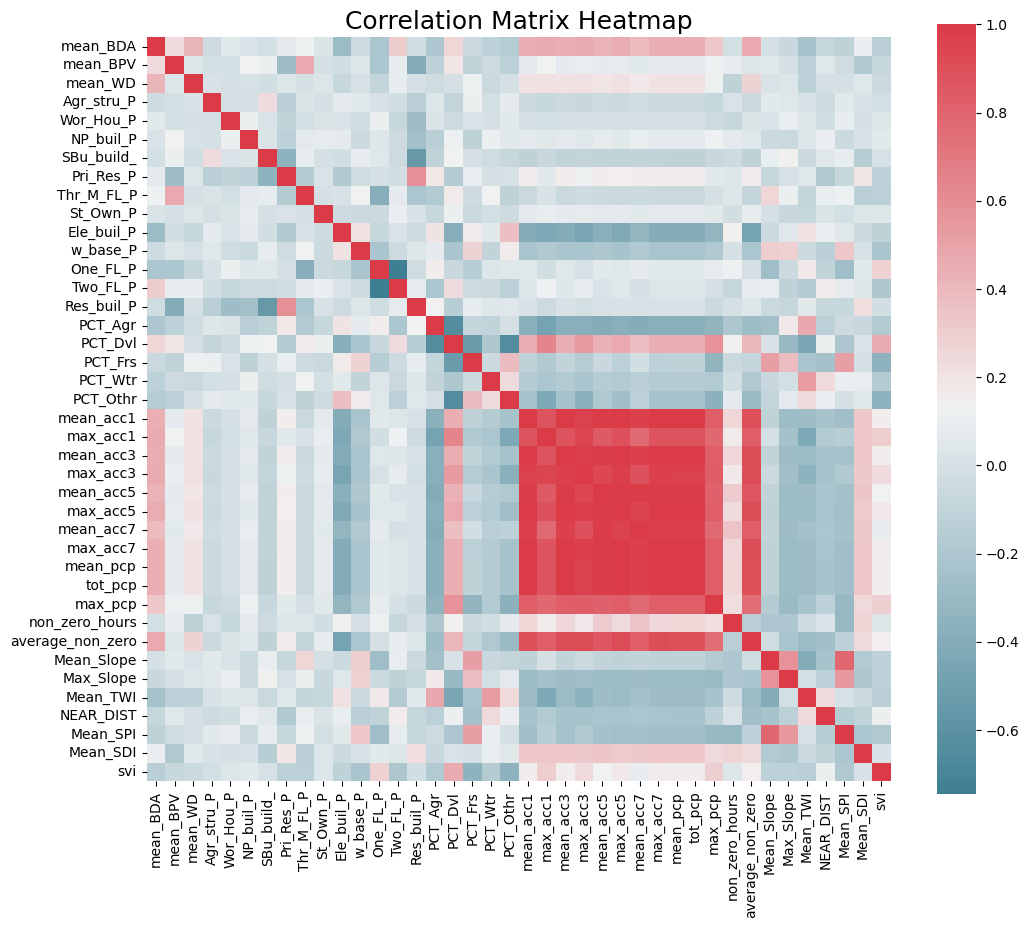

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

correlation_matrix = df_final.iloc[:, 6:].corr()


ax = sns.heatmap(correlation_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap', size=18)
plt.show()

## Split dataset into train and test

The total number of train dataset is 276
The total number of test dataset is 92


The defined centroid longitute of TX is out of figure boarder! Enter a longitute ranging from -98.49 to -91.70 for this state:  -96.5


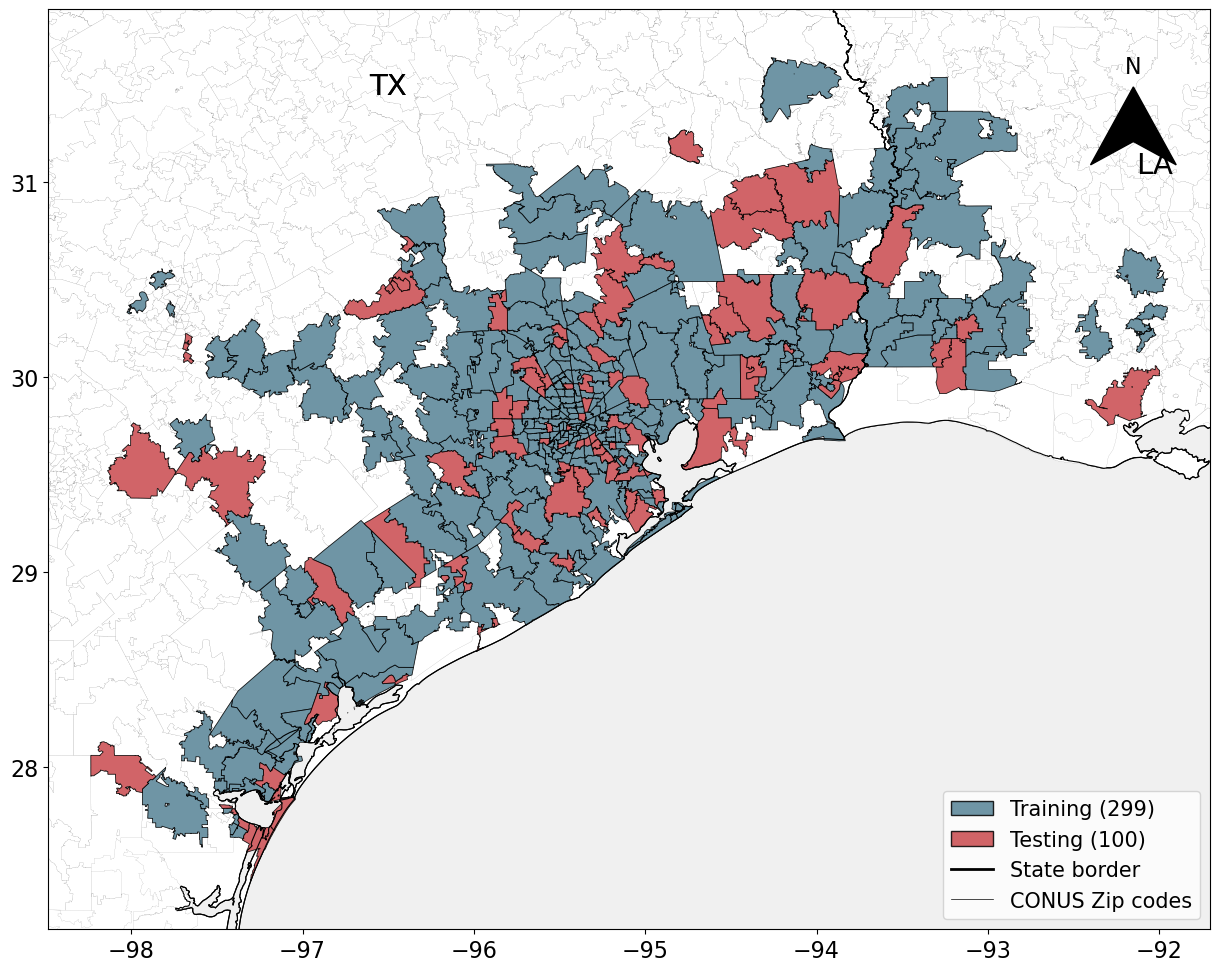

In [26]:
df_final = df_final.sort_values(by='INTPTLAT10')
train_set, test_set = train_test_split(df_final, test_size=0.25, random_state=42, shuffle=True)

print('The total number of train dataset is', len(train_set['ZC5'].value_counts()))
print('The total number of test dataset is', len(test_set['ZC5'].value_counts()))

Map_T1(df_final, train_set, test_set, State_poly, ZC_US_poly, State_Abb, ['#568396', '#C9494D'], 'TrainTestSpatialDistribution')

#train_set.to_excel("./Datasets/Output/BDA/df_Train_BDA_confined.xlsx")
#test_set.to_excel("./Datasets/Output/BDA/df_Test_BDA_confined.xlsx")
#df_final.to_excel("./Datasets/Output/BDA/df_final_BDA_confined.xlsx")